# Introduction

## Background

We, ACME, develop innovative artificial intelligence and computer vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

MonReader is a new mobile document digitalization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

## Dataset

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

## Goal

Predict if the page is being flipped using a single image.


## Success Metrics:

Evaluate model performance based on F1 score, the higher the better.

# Importing Library

In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Project Methodology

We will use following Methodology for this project. 

1. We will use two types of images. Grey scale and colored.


2. Each image will be pre-processed.


3. Pre-processed image data will be feed into CNN.(Convolutional Neural Network).

# Reading images in Grey scale

In [2]:
def read_images(folder):
    images = []
    for filename in tqdm(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename), 0)
        
        if img is not None:
            img = cv2.resize(img, dsize = (70,140), interpolation=cv2.INTER_CUBIC)
            y,h,x,w = 0,100,0,70
            img = img[y:y+h, x:x+w]
            # Adjust brightness, contrast
            alpha=1.5
            beta=0.5
            img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)

            # Normalize the images to be black and white by reverting the images and then dividing by 255.0
            img = cv2.bitwise_not(img)
            img = img/255
            
            images.append(img)



    return images

In [3]:
train_notflip = read_images("images/training/notflip")
train_flip = read_images("images/training/flip")

100%|██████████| 1162/1162 [00:23<00:00, 49.87it/s]


In [4]:
train_notflip[0].shape

(100, 70)

In [5]:
X_noflip = np.array(train_notflip)#.reshape(len(train_notflip), train_notflip[0].shape[0] * train_notflip[0].shape[1])
X_flip = np.array(train_flip)#.reshape(len(train_flip), train_flip[0].shape[0] * train_flip[0].shape[1])
y_noflip = np.zeros(X_noflip.shape[0])
y_flip = np.ones(X_flip.shape[0])

In [6]:
X = np.concatenate((X_noflip,X_flip ))

total_train_images = X.shape[0]
image_height = X.shape[1]
image_width = X.shape[2]

X_resize = X.reshape(total_train_images, image_width, image_height, 1)

In [7]:
X_resize.shape

(2392, 70, 100, 1)

In [8]:
y = np.concatenate((y_noflip, y_flip))
y.shape

(2392,)

We will seperate train data into train and validation states. This will help us to determine right parameters before applying neural network to test dataset.

In [9]:


X_train, X_val, y_train, y_val = train_test_split(X_resize, y , test_size = 0.3, random_state = 42)

In [4]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from tensorflow import keras
# from keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.layers import (Flatten, Dense, Activation, MaxPooling2D, Conv2D, InputLayer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

In [11]:
# Define a function with the neural networks

def neural_network():
    model = Sequential()
    model.add(Conv2D(32, (2, 2), activation = 'relu', kernel_initializer='he_uniform', 
                     padding = 'same', input_shape=(100, 70,1)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    

    return model

In [12]:
# Fit model

model = neural_network()

# fit model
model.fit(X_train, y_train, epochs = 15, validation_data=(X_val, y_val))



Epoch 1/15
53/53 [==============================] - 5s 88ms/step - loss: 0.5756 - accuracy: 0.6712 - val_loss: 0.3459 - val_accuracy: 0.8482
Epoch 2/15
53/53 [==============================] - 4s 72ms/step - loss: 0.2985 - accuracy: 0.8818 - val_loss: 0.2302 - val_accuracy: 0.9206
Epoch 3/15
53/53 [==============================] - 4s 75ms/step - loss: 0.1773 - accuracy: 0.9434 - val_loss: 0.2925 - val_accuracy: 0.8872
Epoch 4/15
53/53 [==============================] - 4s 79ms/step - loss: 0.1728 - accuracy: 0.9377 - val_loss: 0.1615 - val_accuracy: 0.9387
Epoch 5/15
53/53 [==============================] - 4s 77ms/step - loss: 0.1015 - accuracy: 0.9724 - val_loss: 0.1547 - val_accuracy: 0.9387
Epoch 6/15
53/53 [==============================] - 4s 78ms/step - loss: 0.0774 - accuracy: 0.9860 - val_loss: 0.1361 - val_accuracy: 0.9471
Epoch 7/15
53/53 [==============================] - 4s 77ms/step - loss: 0.0648 - accuracy: 0.9891 - val_loss: 0.1184 - val_accuracy: 0.9540
Epoch 8/15
53

# Test Dataset for grey scale images

In [13]:
test_notflip = read_images("images/testing/notflip")
test_flip = read_images("images/testing/flip")

100%|██████████| 290/290 [00:05<00:00, 49.13it/s]


In [14]:
X_test_noflip = np.array(test_notflip)#.reshape(len(train_notflip), train_notflip[0].shape[0] * train_notflip[0].shape[1])
X_test_flip = np.array(test_flip)#.reshape(len(train_flip), train_flip[0].shape[0] * train_flip[0].shape[1])
y_test_noflip = np.zeros(X_test_noflip.shape[0])
y_test_flip = np.ones(X_test_flip.shape[0])


test_X = np.concatenate((X_test_noflip,X_test_flip ))

total_test_images = test_X.shape[0]
image_height = test_X.shape[1]
image_width = test_X.shape[2]

test_X_resize = test_X.reshape(total_test_images, image_width, image_height, 1)

In [15]:
test_y = np.concatenate((y_test_noflip, y_test_flip))
test_y.shape

(597,)

In [16]:
model.evaluate(test_X_resize, test_y)

19/19 [==============================] - 0s 19ms/step - loss: 0.1209 - accuracy: 0.9581


[0.12085286527872086, 0.9581239819526672]

As we can see that Grey scale images accuracy is approx. 96%. 


# Colored Images

In [17]:
def read_images(folder):
    images = []
    for filename in tqdm(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename))
        
        if img is not None:
            img = cv2.resize(img, dsize = (70,140), interpolation=cv2.INTER_CUBIC)
            y,h,x,w = 0,100,0,70
            img = img[y:y+h, x:x+w]
            # Adjust brightness, contrast
            alpha=1.5
            beta=0.5
            img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)

            # Normalize the images to be black and white by reverting the images and then dividing by 255.0
            img = cv2.bitwise_not(img)
            img = img/255
            
            images.append(img)



    return images

In [18]:
train_notflip = read_images("images/training/notflip")
train_flip = read_images("images/training/flip")

100%|██████████| 1162/1162 [00:28<00:00, 40.77it/s]


In [19]:
train_notflip[0].shape

(100, 70, 3)

In [20]:
X_noflip = np.array(train_notflip)#.reshape(len(train_notflip), train_notflip[0].shape[0] * train_notflip[0].shape[1])
X_flip = np.array(train_flip)#.reshape(len(train_flip), train_flip[0].shape[0] * train_flip[0].shape[1])
y_noflip = np.zeros(X_noflip.shape[0])
y_flip = np.ones(X_flip.shape[0])

In [21]:
X = np.concatenate((X_noflip,X_flip ))

total_train_images = X.shape[0]
image_height = X.shape[1]
image_width = X.shape[2]

# X_resize = X.reshape(total_train_images, image_width, image_height, 1)
X.shape

(2392, 100, 70, 3)

In [22]:
y = np.concatenate((y_noflip, y_flip))
y.shape

(2392,)

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y , test_size = 0.3, random_state = 42)

In [24]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from tensorflow import keras
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.layers import (Flatten, Dense, Activation, MaxPooling2D, Conv2D, InputLayer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

### CNN Theory

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other.

Below image shows example of Convolutional Neural Network.
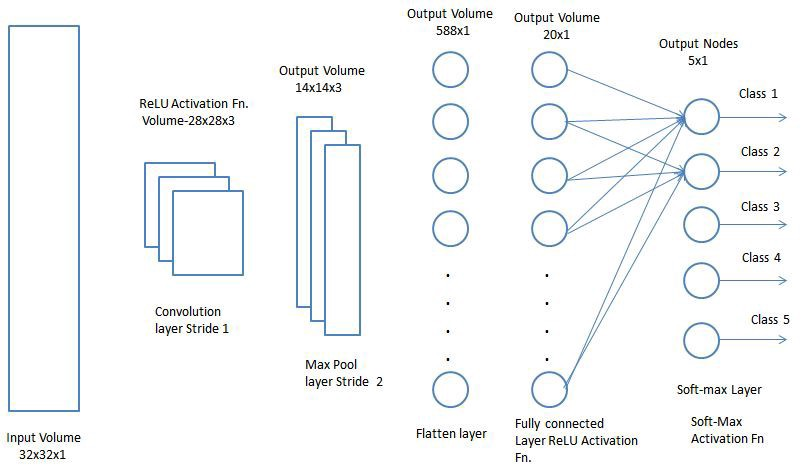

Adding a Fully-Connected layer is a (usually) cheap way of learning non-linear combinations of the high-level features as represented by the output of the convolutional layer. The Fully-Connected layer is learning a possibly non-linear function in that space.

Now that we have converted our input image into a suitable form for our Multi-Level Perceptron, we shall flatten the image into a column vector. The flattened output is fed to a feed-forward neural network and backpropagation applied to every iteration of training. Over a series of epochs, the model is able to distinguish between dominating and certain low-level features in images and classify them using the Softmax Classification technique.

In [25]:
# Define a function with the neural networks

def neural_network():
    model = Sequential()
    model.add(Conv2D(32, (2, 2), activation = 'relu', kernel_initializer='he_uniform', 
                     padding = 'same', input_shape=(100, 70,3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    

    return model

In [26]:
# Fit model

model = neural_network()

# fit model
model.fit(X_train, y_train, epochs = 15, validation_data=(X_val, y_val))



Epoch 1/15
53/53 [==============================] - 5s 91ms/step - loss: 0.5728 - accuracy: 0.6594 - val_loss: 0.3447 - val_accuracy: 0.8565
Epoch 2/15
53/53 [==============================] - 4s 80ms/step - loss: 0.2333 - accuracy: 0.9394 - val_loss: 0.2117 - val_accuracy: 0.9304
Epoch 3/15
53/53 [==============================] - 4s 80ms/step - loss: 0.1493 - accuracy: 0.9605 - val_loss: 0.1632 - val_accuracy: 0.9485
Epoch 4/15
53/53 [==============================] - 4s 81ms/step - loss: 0.1182 - accuracy: 0.9756 - val_loss: 0.1668 - val_accuracy: 0.9429
Epoch 5/15
53/53 [==============================] - 4s 81ms/step - loss: 0.0912 - accuracy: 0.9824 - val_loss: 0.1306 - val_accuracy: 0.9582
Epoch 6/15
53/53 [==============================] - 4s 81ms/step - loss: 0.0641 - accuracy: 0.9920 - val_loss: 0.0832 - val_accuracy: 0.9777
Epoch 7/15
53/53 [==============================] - 4s 81ms/step - loss: 0.0530 - accuracy: 0.9913 - val_loss: 0.0770 - val_accuracy: 0.9833
Epoch 8/15
53

In [27]:
test_notflip = read_images("images/testing/notflip")
test_flip = read_images("images/testing/flip")

100%|██████████| 290/290 [00:06<00:00, 41.71it/s]


In [28]:
X_test_noflip = np.array(test_notflip)#.reshape(len(train_notflip), train_notflip[0].shape[0] * train_notflip[0].shape[1])
X_test_flip = np.array(test_flip)#.reshape(len(train_flip), train_flip[0].shape[0] * train_flip[0].shape[1])
y_test_noflip = np.zeros(X_test_noflip.shape[0])
y_test_flip = np.ones(X_test_flip.shape[0])


test_X = np.concatenate((X_test_noflip,X_test_flip ))

total_test_images = test_X.shape[0]
image_height = test_X.shape[1]
image_width = test_X.shape[2]

test_X.shape
# test_X_resize = test_X.reshape(total_test_images, image_width, image_height, 1)

(597, 100, 70, 3)

In [29]:
test_y = np.concatenate((y_test_noflip, y_test_flip))
test_y.shape

(597,)

In [30]:
model.evaluate(test_X, test_y)

19/19 [==============================] - 0s 20ms/step - loss: 0.0589 - accuracy: 0.9866


[0.05888734012842178, 0.9865996837615967]

We can see that colored images have accuracy improved to 99%.

# Video Analysis

This is a additional part of project where we are going to convert images into videos and then analyze each frame of videos. 

## Video Creation

In [2]:
import glob
from moviepy.editor import VideoFileClip, concatenate_videoclips
import math 

In [5]:
# Define functions to create a video from images

def video_creator(path, pathIn, time, fps):
    frame_video = []
    for i in path:
        img = cv2.imread(i)
        height, width, layers = img.shape
        size = (width, height)
#         print(size)
        frame_video.append(img)
    out = cv2.VideoWriter(pathIn, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
    for i in range(len(path)):
        out.write(frame_video[i])
    
    out.release()

In [7]:
# Create the video for the training flip
# Establish the path to read all of the images 

path_training_flip = glob.glob('video_images/training/flip/*.jpg')

path_training_notflip = glob.glob('video_images/training/notflip/*.jpg')

path_testing_flip = glob.glob('video_images/testing/flip/*.jpg')

path_testing_notflip = glob.glob('video_images/testing/notflip/*.jpg')


# print(path_training_flip)
# Create the video for the training flip

video_creator(path = path_training_flip, pathIn = 'training_flip.avi', time = len(path_training_flip), fps = 1)

# Create the video for the training not flip

video_creator(path = path_training_notflip, pathIn = 'training_notflip.avi', time = len(path_training_notflip), fps = 1)

# Create the video for the test flip

video_creator(path = path_testing_flip, pathIn = 'test_flip.avi', time = len(path_testing_flip), fps = 1)

# Create the video for the test not flip

video_creator(path = path_testing_notflip, pathIn = 'test_notflip.avi', time = len(path_testing_notflip), fps = 1)

In [10]:
# Establish the training video by concatenating the flips with the not flips for train and test data sets.

#Establish the train video

video_1 = VideoFileClip('training_flip.avi')
video_2 = VideoFileClip('training_notflip.avi')

training_video = concatenate_videoclips([video_1, video_2])

training_video.write_videofile('training_video2.avi', codec = 'rawvideo')
training_video.close()

t:   0%|          | 0/592 [00:00<?, ?it/s, now=None]

Moviepy - Building video training_video2.avi.
Moviepy - Writing video training_video2.avi



Moviepy - Done !
Moviepy - video ready training_video2.avi


In [11]:
# Establish the test video

video_3 = VideoFileClip('test_flip.avi')
video_4 = VideoFileClip('test_notflip.avi')

test_video= concatenate_videoclips([video_3, video_4])

test_video.write_videofile('test_video2.avi', codec = 'rawvideo')
test_video.close()

t:   0%|          | 0/162 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_video2.avi.
Moviepy - Writing video test_video2.avi



Moviepy - Done !
Moviepy - video ready test_video2.avi


In [12]:
# Separate the frames for the training video

count = 0

videoFile = 'training_video1.avi'
# Capturing the video from the given path
cap = cv2.VideoCapture(videoFile)   
# Establish Frame rate
frameRate = cap.get(5) 

x=1

filenames_train = []

while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        filenames_train.append(filename)
        cv2.imwrite(filename, frame)
cap.release()
cv2.destroyAllWindows()

In [13]:
# Separate the frames from the test video

count = 0

videoFile = 'test_video1.avi'
# Capturing the video from the given path
cap = cv2.VideoCapture(videoFile)   
# Establish Frame rate
frameRate = cap.get(5) 

x=1

filenames_test = []

while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        filenames_test.append(filename)
        cv2.imwrite(filename, frame)
cap.release()
cv2.destroyAllWindows()

In [14]:
len(path_training_flip)

304

In [15]:
# Append the y_train flip and not flip into the same array

y_train_video_flip = np.ones(len(path_training_flip))
y_train_video_notflip = np.zeros(len(path_training_notflip))
y_test_video_flip = np.ones(len(path_testing_flip))
y_test_video_notflip = np.zeros(len(path_testing_notflip))

y_train_video = np.append(np.array(y_train_video_flip), np.array(y_train_video_notflip))
y_test_video = np.append(np.array(y_test_video_flip), np.array(y_test_video_notflip))


data_train = pd.DataFrame({'frameID': filenames_train, 'flip': y_train_video})
data_test = pd.DataFrame({'frameID': filenames_test, 'flip': y_test_video})

In [16]:
# Randomly change the data order and reset the index
X = []

for img_name in tqdm(data_train.frameID):
    img = plt.imread('' + img_name)
    X.append(img)
X = np.array(X)
y = data_train['flip']



100%|██████████| 592/592 [00:19<00:00, 31.15it/s]


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train , y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [18]:
# Define a function to do the preprocessing for each frame of image of the video

def image_preprocessing_frame(data):
    # Create an empty list to store all the preprocessed images
    images = []
    # Start by creating a for loop through all the path and make the preprocessing to each image
    for i in data:
        # Adjust the size so all iamges will have the same size
        img = cv2.resize(i, dsize = (70,140), interpolation=cv2.INTER_CUBIC)
        # Crop to remove part of the images I don't need for the modeling part
        y,h,x,w = 0,100,0,70
        img = img[y:y+h, x:x+w]
        # Adjust brightness, contrast
        alpha=1.5
        beta=0.5
        img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
        # Append the img to the list images
        images.append(img)
        # Create the video

    # Return the list with the preprocessed images
    return images

In [19]:
X_train = image_preprocessing_frame(data = X_train)

X_val = image_preprocessing_frame(data = X_val)

In [20]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from tensorflow import keras
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.layers import (Flatten, Dense, Activation, MaxPooling2D, Conv2D, InputLayer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

In [21]:
# Include_top=False to remove the top layer and a base model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 70, 3))

In [22]:
# Convert the list into arrays

X_train = np.array(X_train)

X_val = np.array(X_val)

In [23]:
X_train = base_model.predict(X_train)

X_val = base_model.predict(X_val)

X_train.shape, X_val.shape

((473, 3, 2, 512), (119, 3, 2, 512))

In [24]:
# Centering the data

X_train = X_train/X_train.max()

X_val = X_val/X_val.max()

In [44]:
# Define the neural network to use to predict if the frame of the video is flip or not flip
from keras.layers import LeakyReLU
def model_neural():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), kernel_initializer='he_uniform', 
                     padding = 'same', input_shape=(3, 2, 512)))
    model.add(LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [45]:
# Use the function with the created model

model = model_neural()

model.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val))

Epoch 1/100
15/15 [==============================] - 1s 16ms/step - loss: 0.6910 - accuracy: 0.5113 - val_loss: 0.6828 - val_accuracy: 0.5882
Epoch 2/100
15/15 [==============================] - 0s 6ms/step - loss: 0.6858 - accuracy: 0.6108 - val_loss: 0.6766 - val_accuracy: 0.7647
Epoch 3/100
15/15 [==============================] - 0s 6ms/step - loss: 0.6813 - accuracy: 0.7134 - val_loss: 0.6706 - val_accuracy: 0.7983
Epoch 4/100
15/15 [==============================] - 0s 6ms/step - loss: 0.6759 - accuracy: 0.7412 - val_loss: 0.6644 - val_accuracy: 0.7815
Epoch 5/100
15/15 [==============================] - 0s 7ms/step - loss: 0.6683 - accuracy: 0.7978 - val_loss: 0.6574 - val_accuracy: 0.7815
Epoch 6/100
15/15 [==============================] - 0s 6ms/step - loss: 0.6632 - accuracy: 0.7814 - val_loss: 0.6504 - val_accuracy: 0.7983
Epoch 7/100
15/15 [==============================] - 0s 6ms/step - loss: 0.6556 - accuracy: 0.8128 - val_loss: 0.6434 - val_accuracy: 0.7899
Epoch 8/100


Epoch 59/100
15/15 [==============================] - 0s 6ms/step - loss: 0.3907 - accuracy: 0.8431 - val_loss: 0.3701 - val_accuracy: 0.8319
Epoch 60/100
15/15 [==============================] - 0s 6ms/step - loss: 0.3714 - accuracy: 0.8443 - val_loss: 0.3678 - val_accuracy: 0.8403
Epoch 61/100
15/15 [==============================] - 0s 6ms/step - loss: 0.3750 - accuracy: 0.8605 - val_loss: 0.3657 - val_accuracy: 0.8403
Epoch 62/100
15/15 [==============================] - 0s 6ms/step - loss: 0.3673 - accuracy: 0.8509 - val_loss: 0.3637 - val_accuracy: 0.8487
Epoch 63/100
15/15 [==============================] - 0s 6ms/step - loss: 0.3668 - accuracy: 0.8593 - val_loss: 0.3641 - val_accuracy: 0.8403
Epoch 64/100
15/15 [==============================] - 0s 6ms/step - loss: 0.4013 - accuracy: 0.8499 - val_loss: 0.3613 - val_accuracy: 0.8487
Epoch 65/100
15/15 [==============================] - 0s 6ms/step - loss: 0.3338 - accuracy: 0.8863 - val_loss: 0.3598 - val_accuracy: 0.8487
Epoch 

In [46]:
# Randomly change the data order and reset the index
X_test = []

for img_name in tqdm(data_test.frameID):
    img = plt.imread('' + img_name)
    X_test.append(img)
X_test = np.array(X_test)
y_test = data_test['flip']

100%|██████████| 162/162 [00:04<00:00, 36.20it/s]


In [47]:
X_test = image_preprocessing_frame(data = X_test)
X_test = np.array(X_test)
X_test = base_model.predict(X_test)
X_test = X_test/X_test.max()

In [48]:
# Get the predictions

predictions = model.predict(X_test)

# Get them into 0 and 1 values

binary_values = []

# Start a for loop to iterate over the predictions array

for i in predictions:
    if i < 0.5:
        binary_values.append(0)
    if i >= 0.5:
        binary_values.append(1)

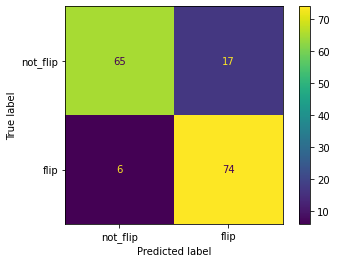

In [49]:
# Display the confusion matrix to evaluate the model
from sklearn.metrics import (confusion_matrix, classification_report, ConfusionMatrixDisplay)

cm = confusion_matrix(y_test, binary_values)
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_flip','flip'])
cmd.plot()

plt.show()

In [50]:
print(classification_report(y_test, binary_values))

              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85        82
         1.0       0.81      0.93      0.87        80

    accuracy                           0.86       162
   macro avg       0.86      0.86      0.86       162
weighted avg       0.86      0.86      0.86       162



WE can see accuracy of 86% is achieved. 